In [1]:
import os
os.environ["PROJ_LIB"] = r'C:\Users\Mic Mic\anaconda3\pkgs\basemap-1.3.0-py38ha7665c8_0\Library\share\basemap' #fixr

from mpl_toolkits.basemap import Basemap, maskoceans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import netCDF4 as nc

### Get latitudes and longitudes of set domain

In [2]:
slp_latitude = np.arange(5,31,1.25)
slp_longitude = np.arange(105,136,1.25)

## Loop through all test years to get composite rain

In [3]:
number_of_days = np.cumsum(np.load('test_number_of_days.npy'))
years_array = np.load('years_array.npy')

### Read csv files of archetypes and weights for RH

In [4]:
MVSA_daily_rh = pd.read_csv('../Training/Medium Domain/rh_training_MVSA.csv',header=None)
daily_rh_weights = pd.read_csv('../Training/Medium Domain/rh_test_weights.csv',header=None).values

### Read csv files of archetypes and weights for SLP

In [5]:
MVSA_daily_slp = pd.read_csv('../Training/Medium Domain/slp_training_MVSA.csv',header=None)
daily_slp_weights = pd.read_csv('../Training/Medium Domain/slp_test_weights.csv',header=None).values

### Get test dates and test RH and SLP values

In [6]:
test_index = np.load('../Training/Medium Domain/test_index.npy')
train_index = np.load('../Training/Medium Domain/training_index.npy')

In [7]:
training_days = np.load('training_days.npy')
test_days = training_days[test_index]

test_rh = pd.read_csv('../Training/Medium Domain/test_RH.csv',header=None).values
test_slp = pd.read_csv('../Training/Medium Domain/test_SLP.csv',header=None).values.T

## Create composite rainfall, SLP, and RH maps

In [8]:
#read archetype rain
archetype_rain = np.load('../Training/Medium Domain/rh_training_rain.npy')

# Initiate composite rain map
composite_rain_map = np.zeros((archetype_rain.shape[0],archetype_rain.shape[1],daily_rh_weights.shape[1]))
actual_rain_map = np.copy(composite_rain_map)

# Initiate composite RH map
# composite_rh_map = np.zeros((3,7,daily_rh_weights.shape[1]))
# actual_rh_map = np.copy(composite_rh_map)

# Initiate composite SLP map
composite_slp_map = np.zeros((len(slp_latitude),len(slp_longitude),daily_slp_weights.shape[1]))
actual_slp_map = np.copy(composite_slp_map)

for m in range(daily_rh_weights.shape[1]):
    # Get RH weights for each test date
    test_weights = daily_rh_weights[:,m]
    
    # Get SLP weights for each test date
    test_slp_weights = daily_slp_weights[:,m]

    for n in range(daily_rh_weights.shape[0]):
        # Multiply each archetype rain map by corresponding weights
        composite_rain_map[:,:,m] += test_weights[n]*archetype_rain[:,:,n]

        # Multiply each archetype RH map by corresponding weights
#         archetype_rh = np.reshape(MVSA_daily_rh[n].values,(3,7))
#         composite_rh_map[:,:,m] += test_weights[n]*archetype_rh
    
    for p in range(daily_slp_weights.shape[0]):
        # Multiply each archetype SLP map by corresponding weights
        archetype_slp = np.reshape(MVSA_daily_slp[p].values,(len(slp_latitude),len(slp_longitude)))
        composite_slp_map[:,:,m] += test_slp_weights[p]*archetype_slp

    #read daily rain corresponding to month and day
    try:
        daily_rain = nc.Dataset('../../Daily Rain/gpm'+test_days[m][:4]+'/3B-DAY.MS.MRG.3IMERG.'+test_days[m] \
                                +'-S000000-E235959.V06.nc4.nc4')
    except FileNotFoundError:
        continue
    
    # Get actual rain
    rain_data = np.ma.getdata(daily_rain['precipitationCal'][0,:,:])
    actual_rain_map[:,:,m] = rain_data.T
    
    # Get actual RH
#     actual_rh_map[:,:,m] = np.reshape(test_rh[m,:],(3,7))
    
    # Get actual SLP
    actual_slp_map[:,:,m] = np.reshape(test_slp[m,:],(len(slp_latitude),len(slp_longitude)))

### Calculate 2D correlation coefficient between SLP maps

In [9]:
#correlation coefficient based on equation used in Matlab's corr2 function
def corr2(arr1,arr2):
    num1 = arr1 - np.mean(arr1)
    num2 = arr2 - np.mean(arr2)
    numerator = np.sum((num1*num2))
    
    denom1 = np.sum(num1**2)
    denom2 = np.sum(num2**2)
    denominator = np.sqrt(denom1*denom2)
    
    return (numerator/denominator)

## Compare composite vs actual SLP

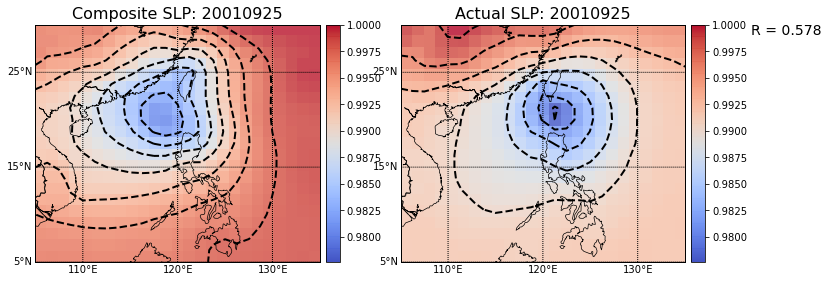

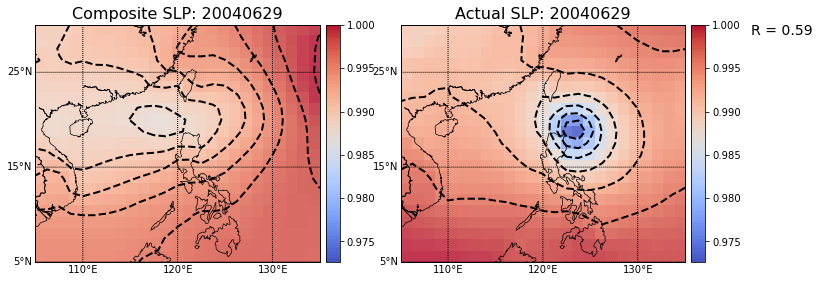

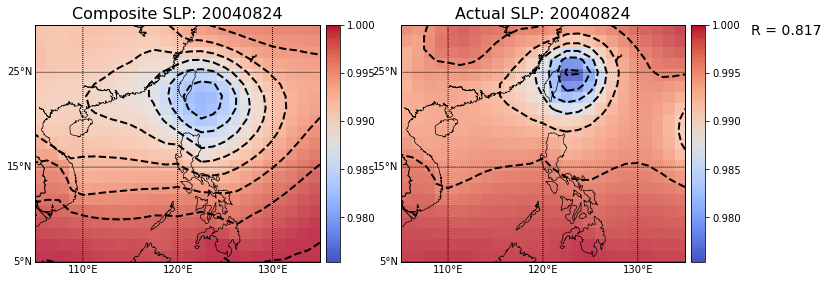

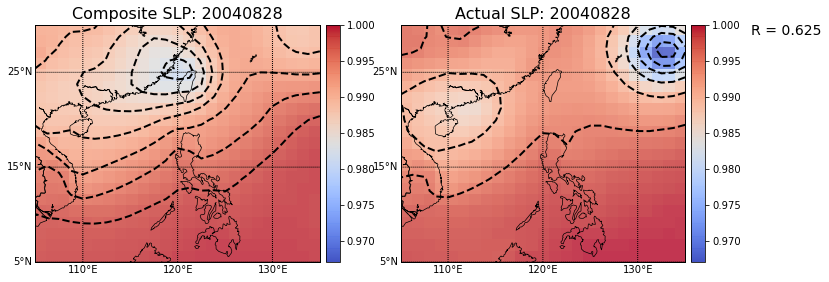

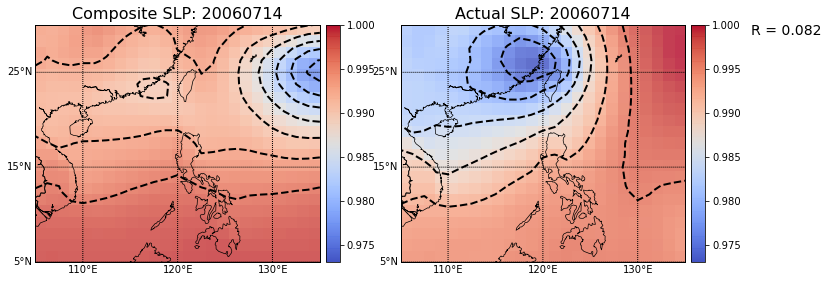

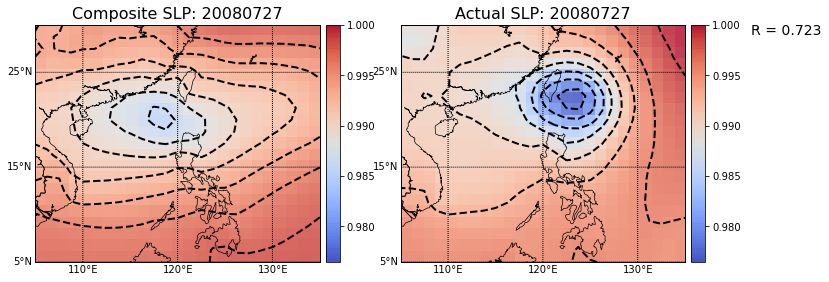

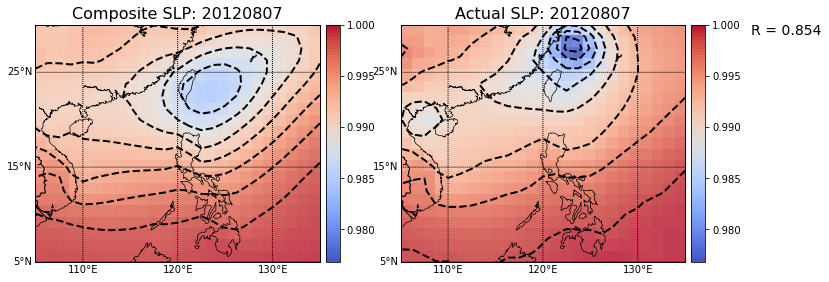

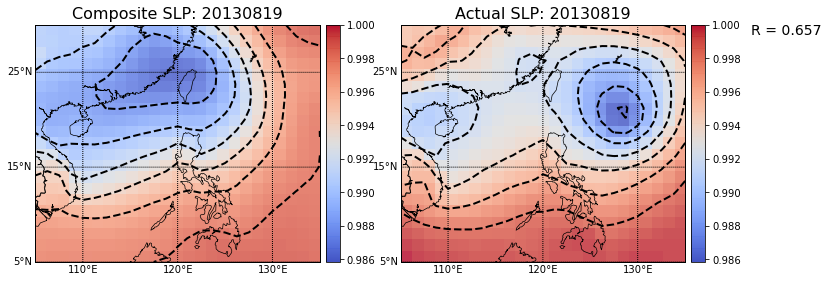

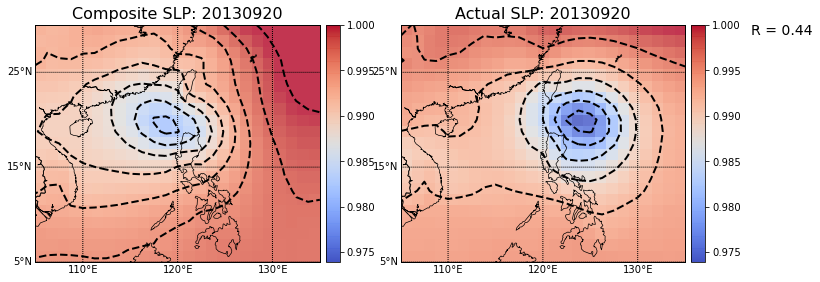

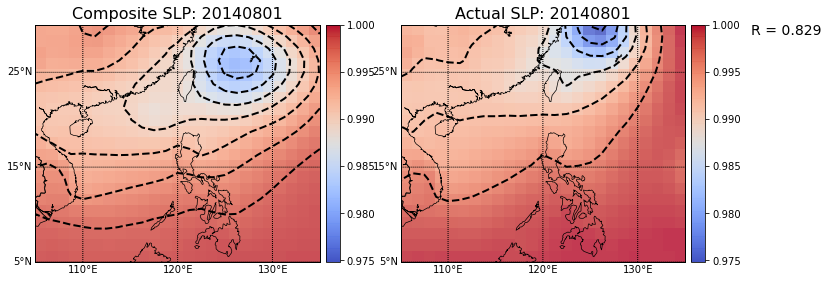

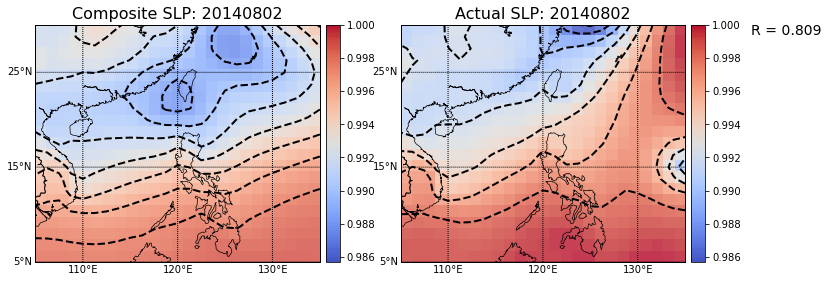

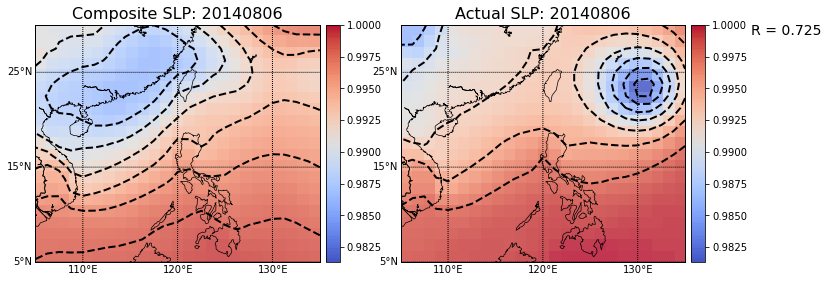

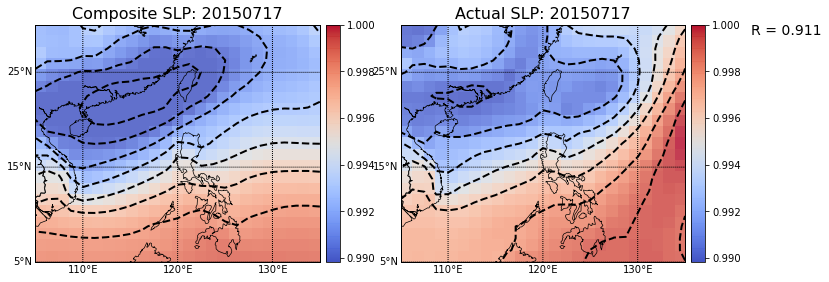

In [11]:
correlation = []

for j in range(composite_rain_map.shape[2]):
    #get normalized actual SLP
    actual_slp = np.flip(actual_slp_map[:,:,j],axis=0)

    #get normalized composite SLP
    composite_slp = np.flip(composite_slp_map[:,:,j],axis=0) 

    fig = plt.figure(figsize=(12, 10))

    #show composite SLP map
    fig.add_subplot(1, 2, 1)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=105,urcrnrlon=135,llcrnrlat=5,urcrnrlat=30,resolution='l')
    m.drawcoastlines(linewidth=0.7)
    m.drawmapboundary()
    
    #create isobars
    X, Y = np.meshgrid(slp_longitude, slp_latitude)
    contours = plt.contour(X, Y, composite_slp,colors='black',linestyles='dashed',linewidths=2)

    composite_slp_imshow = m.imshow(composite_slp,cmap='coolwarm',alpha=0.8,zorder=1,\
                                   vmin=np.min(actual_slp),vmax=np.max(actual_slp)) #,vmin=0,vmax=1
    plt.title('Composite SLP: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,36,10)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(100,141,10)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(composite_slp_imshow,'right',shrink=0.5)

    #show actual SLP map
    fig.add_subplot(1, 2, 2)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=105,urcrnrlon=135,llcrnrlat=5,urcrnrlat=30,resolution='l')
    m.drawcoastlines(linewidth=0.7)
    m.drawmapboundary()

    #create isobars
    X, Y = np.meshgrid(slp_longitude, slp_latitude)
    contours = plt.contour(X, Y, actual_slp,colors='black',linestyles='dashed',linewidths=2)
    
    actual_slp_imshow = m.imshow(actual_slp,cmap='coolwarm',alpha=0.8,zorder=1) #,vmin=0,vmax=1
    plt.title('Actual SLP: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,36,10)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(100,141,10)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(actual_slp_imshow,'right',shrink=0.5)
    
    corr_coef = corr2(composite_slp,actual_slp)
    correlation.append(corr_coef)
    plt.text(142,29,'R = '+str(np.round(corr_coef,3)),fontsize=14)

    plt.show()

In [12]:
np.median(correlation)

0.7227637032926842

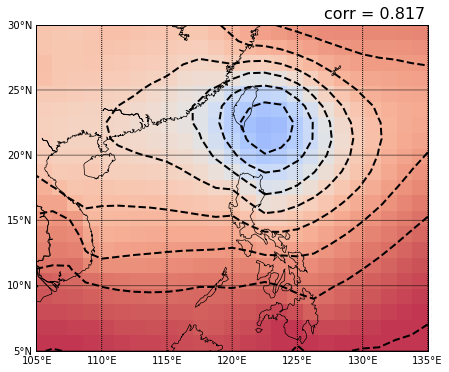

In [10]:
slp_max = [101020]

for j in [2]: 
    #get normalized actual SLP
    actual_slp = np.flip(actual_slp_map[:,:,j],axis=0)

    #get normalized composite SLP
    composite_slp = np.flip(composite_slp_map[:,:,j],axis=0) 

    fig = plt.figure(figsize=(8, 6))

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=105,urcrnrlon=135,llcrnrlat=5,urcrnrlat=30,resolution='l')
    m.drawcoastlines(linewidth=0.7)
    m.drawmapboundary()
    
    #create isobars
    X, Y = np.meshgrid(slp_longitude, slp_latitude)
    contours = plt.contour(X, Y, composite_slp,colors='black',linestyles='dashed',linewidths=2)

    composite_slp_imshow = m.imshow(composite_slp,cmap='coolwarm',alpha=0.8,zorder=1,\
                                   vmin=np.min(actual_slp),vmax=np.max(actual_slp)) #,vmin=0,vmax=1
#     plt.title('Composite SLP: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,36,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(100,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

#     m.colorbar(composite_slp_imshow,'right',shrink=0.5)
    
    corr_coef = corr2(composite_slp,actual_slp)
    plt.text(127,30.5,'corr = '+str(np.round(corr_coef,3)),fontsize=16)
    
#     plt.text(140,27,'Weights',fontsize=14)
#     for p in range(daily_slp_weights.shape[0]):
#         plt.text(140.5,26-p,'arch'+str(p+1)+'='+\
#                  str(np.round(daily_slp_weights[p,j],3)),fontsize=12)
    
    plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/med_hsuslp_'+str(test_days[j])+'.png'\
                ,dpi=300,bbox_inches='tight')
    plt.show()

### Load observed rainfall per station 

In [32]:
obs_rain = pd.read_csv('../obs_strong_habagat.csv',header=None).values

test_obs_rain = obs_rain[test_index]
train_obs_rain = obs_rain[train_index]

### Load indices of longitude and latitude of PAGASA stations in rain grid

In [33]:
luzon_ind = np.load('luzon_index.npy')
obs_rain = pd.read_csv('../obs_strong_habagat.csv',header=None).values[:,luzon_ind]

test_obs_rain = obs_rain[test_index]
train_obs_rain = obs_rain[train_index]

## Compare forecast and actual rainfall, and calculate contingency table

In [38]:
#heavy rain threshold
threshold_rain = [0.5,30]

#neighbour size of forecast
N = [1,2]

#create array containing contingency table per day for different threshold and neighbour size
cont_table = np.zeros((test_obs_rain.shape[0],5,len(threshold_rain),len(N)))

for t in range(len(threshold_rain)):
    for n in range(len(N)):
        for a in range(test_obs_rain.shape[0]):
            #get composite rain
            composite_rain = 3.3728584238048134*composite_rain_map[:,:,a] 

            for b in range(test_obs_rain.shape[1]):
                lat_index = station_lat[b]
                lon_index = station_lon[b]

                #get actual station rain
                actual_station_rain = test_obs_rain[a][b]

                #check if observed rain is missing
                if np.isnan(actual_station_rain):
                    cont_table[a,4,t] += 1

                else:
                    #get composite station rain within grid
                    composite_station_rain = composite_rain[lat_index-N[n]:lat_index+(N[n]+1), \
                                                            lon_index-N[n]:lon_index+(N[n]+1)]

                    #compare actual rain to grid of forecast
                    diff = np.abs(actual_station_rain-composite_station_rain).argmin()
                    forecast_station_rain = composite_station_rain.flatten()[diff]

                    #count hits per day
                    if actual_station_rain >= threshold_rain[t] and forecast_station_rain >= threshold_rain[t]:
                        cont_table[a,0,t,n] += 1

                    #count false alarms per day
                    elif actual_station_rain < threshold_rain[t] and forecast_station_rain >= threshold_rain[t]:
                        cont_table[a,1,t,n] += 1

                    #count misses per day
                    elif actual_station_rain >= threshold_rain[t] and forecast_station_rain < threshold_rain[t]:
                        cont_table[a,2,t,n] += 1

                    #count correct negatives per day
                    else:
                        cont_table[a,3,t,n] += 1

## Calculate contingency scores

In [39]:
# 0 = hits
# 1 = false alarms
# 2 = misses
# 3 = correct negatives

#calculate threat score
ts = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:]+cont_table[:,2,:,:])

#calculate bias
bias = (cont_table[:,0,:,:]+cont_table[:,1,:,:])/(cont_table[:,0,:,:]+cont_table[:,2,:,:])

#calculate probability of detection
pod = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,2,:,:])

#calculate false alarm ratio
far = cont_table[:,1,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:])

<ipython-input-39-380e9cbdd595>:16: RuntimeWarning: invalid value encountered in true_divide
  far = cont_table[:,1,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:])


In [44]:
np.nanmean(np.ma.masked_invalid(far),axis=0)

masked_array(
  data=[[0.40053438, 0.38556139],
        [0.62378441, 0.45047314]],
  mask=False,
  fill_value=1e+20)

## Plot forecast vs actual rainfall with contingency scores

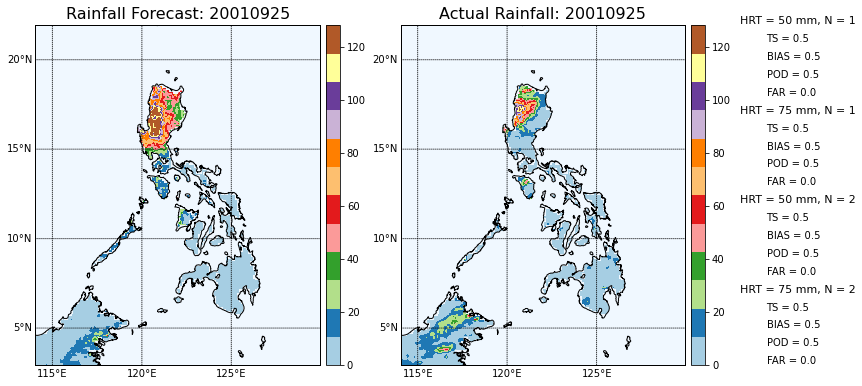

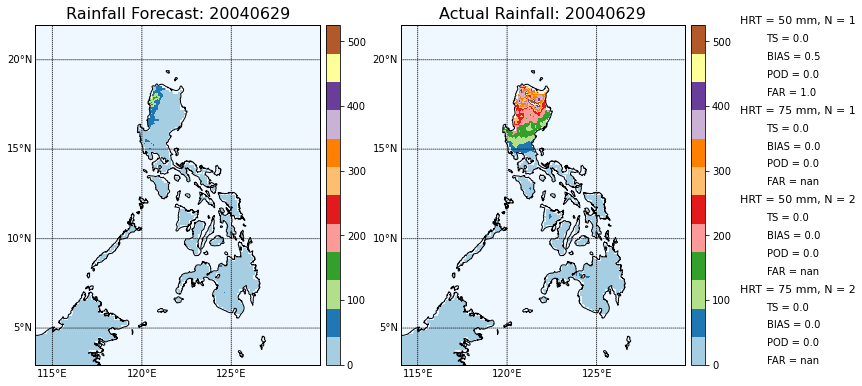

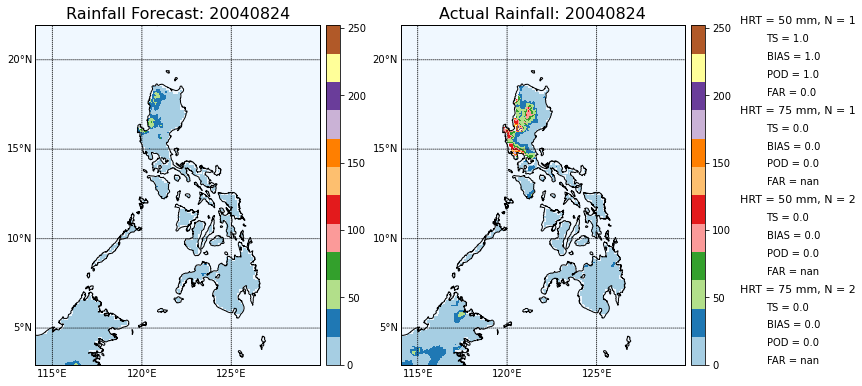

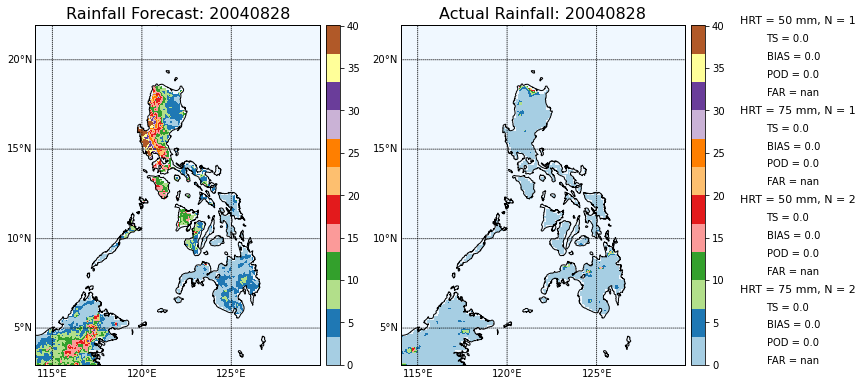

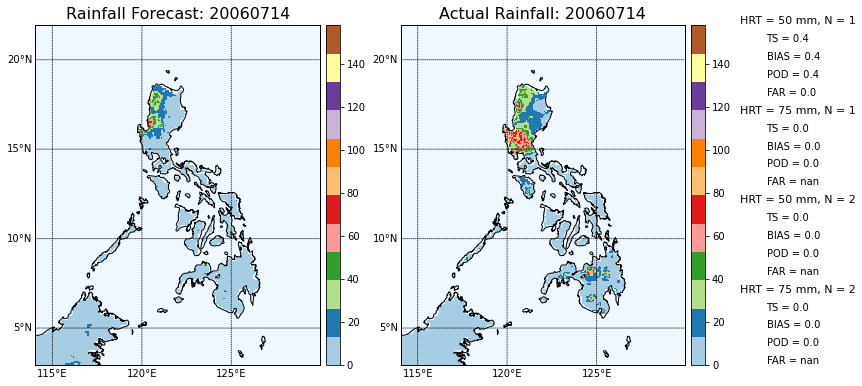

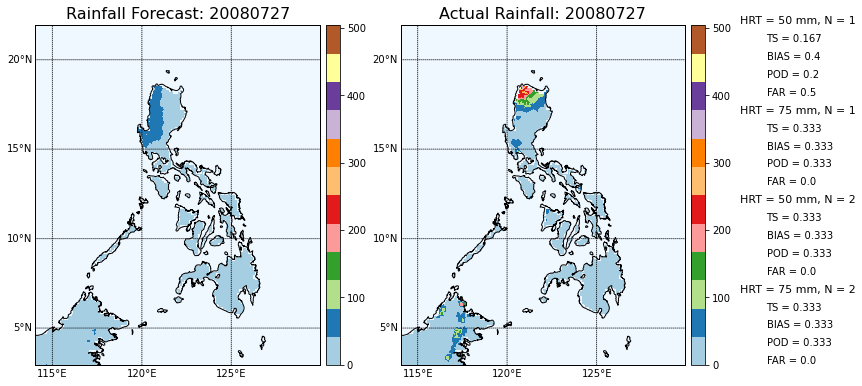

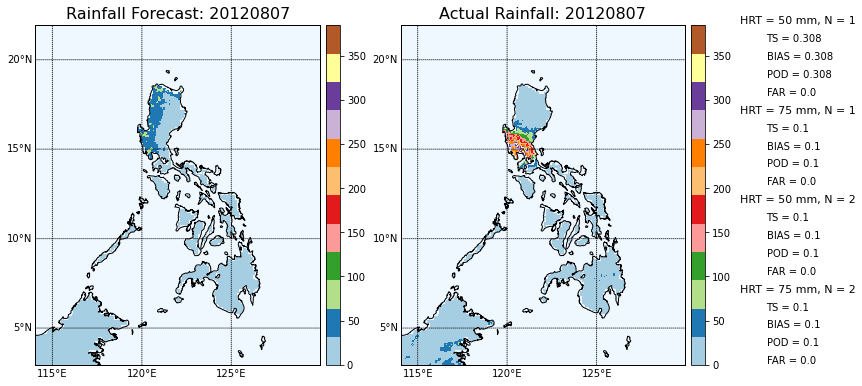

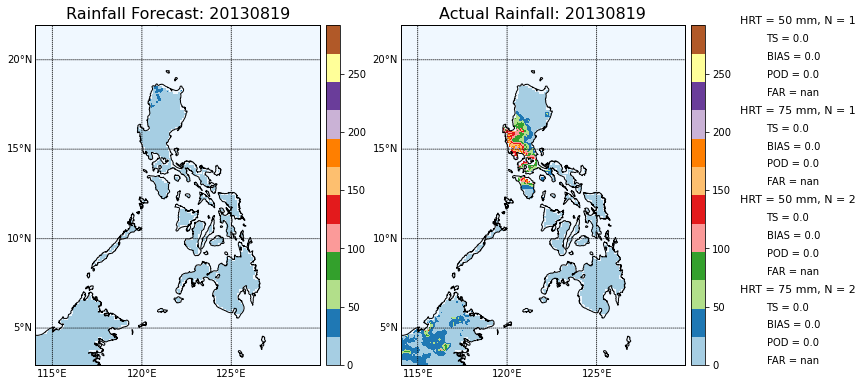

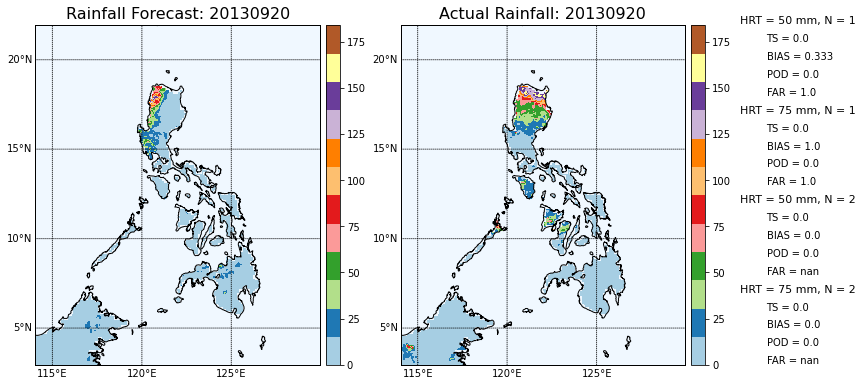

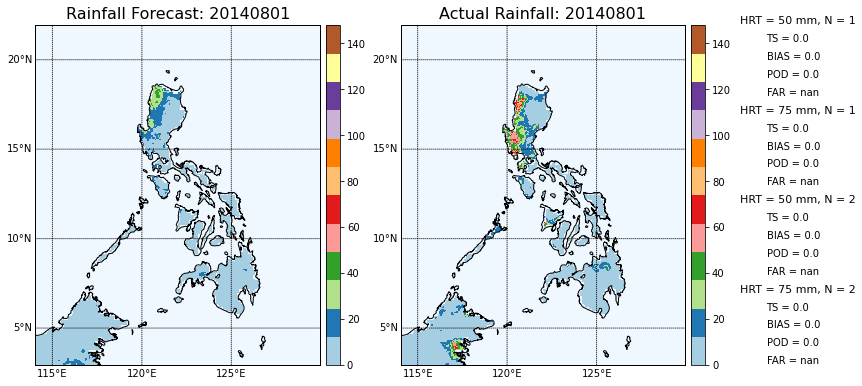

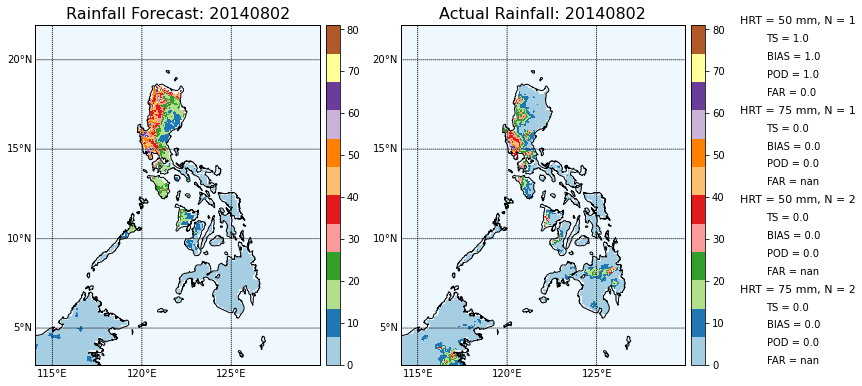

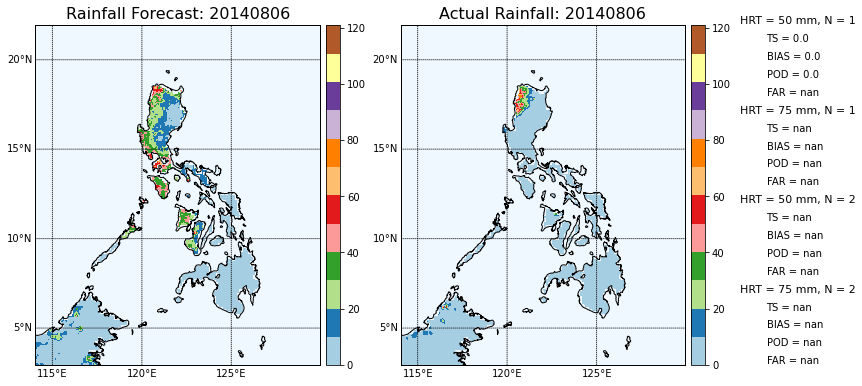

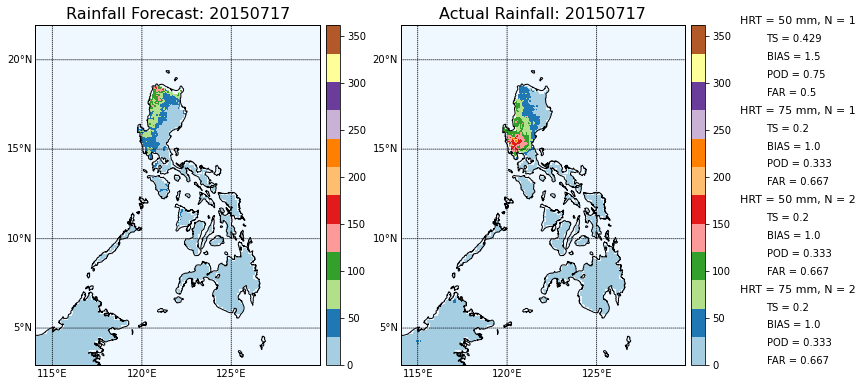

In [14]:
#get latitudes
rain_latitude = np.ma.getdata(daily_rain['lat'])
#get longitudes
rain_longitude = np.ma.getdata(daily_rain['lon'])

lon, lat = np.meshgrid(rain_longitude,rain_latitude)

for j in range(composite_rain_map.shape[2]):
    #get masked actual rain
    actual_rain = actual_rain_map[:,:,j]
    masked_actual = maskoceans(lon,lat,actual_rain,resolution='i')

    #get masked composite rain
    composite_rain = 0.9014993116738215*composite_rain_map[:,:,j] 
    masked_composite = maskoceans(lon,lat,composite_rain,resolution='i')

    fig = plt.figure(figsize=(12, 10))

    #show archetype rain map
    fig.add_subplot(1, 2, 1)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    composite_rain_imshow = m.imshow(masked_composite,cmap='Paired',zorder=1,\
                                     vmin=np.min(masked_actual),vmax=np.max(masked_actual))
    plt.title('Rainfall Forecast: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(composite_rain_imshow,'right',shrink=0.5)

    #show actual rain map
    fig.add_subplot(1, 2, 2)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    actual_rain_imshow = m.imshow(masked_actual,cmap='Paired',zorder=1) 
    plt.title('Actual Rainfall: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(actual_rain_imshow,'right',shrink=0.5)

    #plt.savefig('For Proposal/sample_forecast.png',dpi=600,bbox_inches='tight')
    #plt.savefig('2018 Sample Forecast/'+str(test_days[j])+'.png',dpi=300,bbox_inches='tight')
    
    #display contingency scores at 50mm threshold, N=1
    plt.text(133,22,'HRT = '+str(threshold_rain[0])+' mm, N = '+str(N[0]),fontsize=11)
    plt.text(134.5,21,'TS = '+str(np.round(ts[j,0,0],3)),fontsize=10)
    plt.text(134.5,20,'BIAS = '+str(np.round(bias[j,0,0],3)),fontsize=10)
    plt.text(134.5,19,'POD = '+str(np.round(pod[j,0,0],3)),fontsize=10)
    plt.text(134.5,18,'FAR = '+str(np.round(far[j,0,0],3)),fontsize=10)
    
    #display contingency scores at 75mm threshold, N=1
    plt.text(133,17,'HRT = '+str(threshold_rain[1])+' mm, N = '+str(N[0]),fontsize=11)
    plt.text(134.5,16,'TS = '+str(np.round(ts[j,1,0],3)),fontsize=10)
    plt.text(134.5,15,'BIAS = '+str(np.round(bias[j,1,0],3)),fontsize=10)
    plt.text(134.5,14,'POD = '+str(np.round(pod[j,1,0],3)),fontsize=10)
    plt.text(134.5,13,'FAR = '+str(np.round(far[j,1,0],3)),fontsize=10)
    
    #display contingency scores at 50mm threshold, N=2
    plt.text(133,12,'HRT = '+str(threshold_rain[0])+' mm, N = '+str(N[1]),fontsize=11)
    plt.text(134.5,11,'TS = '+str(np.round(ts[j,1,1],3)),fontsize=10)
    plt.text(134.5,10,'BIAS = '+str(np.round(bias[j,1,1],3)),fontsize=10)
    plt.text(134.5,9,'POD = '+str(np.round(pod[j,1,1],3)),fontsize=10)
    plt.text(134.5,8,'FAR = '+str(np.round(far[j,1,1],3)),fontsize=10)
    
    #display contingency scores at 75mm threshold, N=2
    plt.text(133,7,'HRT = '+str(threshold_rain[1])+' mm, N = '+str(N[1]),fontsize=11)
    plt.text(134.5,6,'TS = '+str(np.round(ts[j,1,1],3)),fontsize=10)
    plt.text(134.5,5,'BIAS = '+str(np.round(bias[j,1,1],3)),fontsize=10)
    plt.text(134.5,4,'POD = '+str(np.round(pod[j,1,1],3)),fontsize=10)
    plt.text(134.5,3,'FAR = '+str(np.round(far[j,1,1],3)),fontsize=10)

    plt.show()